In [28]:
%load_ext autoreload
%autoreload 2

## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

In [31]:
# load some helper utils for running for long time
if not os.path.isfile('workspace_utils.py'):
    !curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py
from workspace_utils import active_session

## Create your training and testing data:

In [22]:
from source.train import _create_dataset
create_new_trainval_set = 0
input_file = '/data/Data_Entry_2017.csv'
output_trainfile = os.path.join('processed_data', 'train_data.csv')
output_valfile = os.path.join('processed_data', 'val_data.csv') 
if create_new_trainval_set:
    _create_dataset(input_file = input_file,
                       output_trainfile = output_trainfile,
                    output_valfile = output_valfile)
train_data, val_data = pd.read_csv(output_trainfile), pd.read_csv(output_valfile)

Scans found: 112120 , Total Headers 112120


## Create your training and testing data:

#### First suggestion: perform some image augmentation on your data

In [114]:
from source.train import TrainGen, make_val_gen

input_file = '/data/Data_Entry_2017.csv'
output_trainfile = os.path.join('processed_data', 'train_data.csv')
train_data, val_data = pd.read_csv(output_trainfile), pd.read_csv(output_valfile)
train_gen = TrainGen(train_data)
def visualize_dataset(ax, pneumonia_count, title):
    pneumonia_count.plot.bar(ax = ax)
    for i in range(2):
        text = f'{pneumonia_count[i]:,}'
        ax.text(i, pneumonia_count[i], text, color='black', ha="center")
    ax.set_xlabel('Pneumonia')
    ax.set_ylabel('The number of non-pneumonia')
    ax.set_title(title)

Found 2304 validated image filenames belonging to 2 classes.


### Visualize training dataset

The training dataset is an imbalanced dataset containing 1,145 pneumonia cases and a total of 89,696 images sampled from 112,120 chest X-ray images with 14 (unique) disease and 'No Finding' labels from 30,805 unique patients.

However, the training dataset for each training epoch contains only 2,304  images and is almost balanced for Pneumonia and Non-Pneumonia labels by the sampling technique as follows.

1. 1,145 images of Pneumonia from training dataset
2. 1,159 images of Non-Pneumonia newly sampled from the training dataset every epoch 

The reason to use 2,304 number is that it can be divided by the batch size 256 that is used in the training process. (e.g. 2,304/256 = 9)

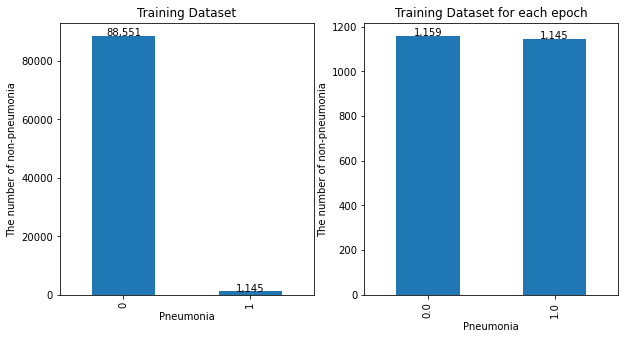

In [115]:
# training dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  
pneumonia_count = train_data.Pneumonia.value_counts()
visualize_dataset(ax1, pneumonia_count, title = 'Training Dataset')

# training dataset for each epoch
all_label_in_this_epochs = []
for i in range(len(train_gen.train_gen)):
    trainX_epoch, trainY_epoch = train_gen.train_gen.next()
    all_label_in_this_epochs.append(trainY_epoch)
all_label_in_this_epochs = np.concatenate(all_label_in_this_epochs)
pneumonia_count = pd.DataFrame(all_label_in_this_epochs, columns = ['Pneumonia']).Pneumonia.value_counts()
visualize_dataset(ax2, pneumonia_count, title = 'Training Dataset for each epoch')
plt.show()

### Visualize validation dataset

The validation dataset is an imbalanced dataset containing 20% pneumonia cases and a total of 1430 images sampled from 112,120 chest X-ray images with 14 (unique) disease and 'No Finding' labels from 30,805 unique patients.

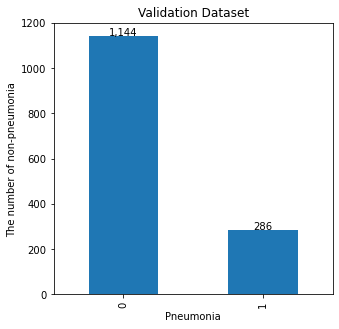

In [116]:
fig, ax = plt.subplots(figsize=(5,5)) 
pneumonia_count = val_data.Pneumonia.value_counts()
visualize_dataset(ax, pneumonia_count, title = 'Validation Dataset')
plt.show()

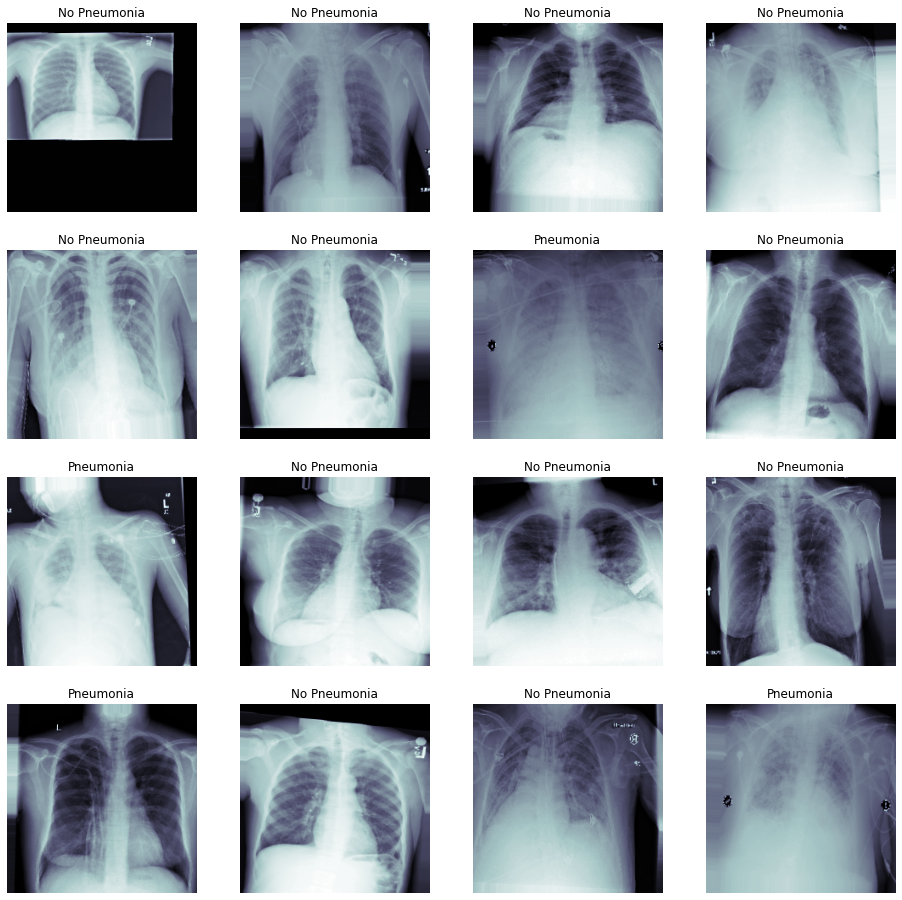

In [7]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen.train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
# train model a bit to find suitable learning rates
from source.model import load_pretrained_VGG16, load_pretrained_ResNet50, build_my_model
from source.train import find_optimal_lr, plot_lr_loss 
import os
find_new_suitable_lr = 0
optimallr_vgg16_path = os.path.join('output', 'optimallr_vgg16.csv')
optimallr_reasnet50_path = os.path.join('output', 'optimallr_resnet50.csv')
if find_new_suitable_lr:
    # find_optimal_lr vgg16  
    pretrained_vgg16 = load_pretrained_VGG16(lay_of_interest = 'block5_pool', trainable_after_layer = 17)
    vgg16 = build_my_model(pretrained_vgg16)
    find_optimal_lr(vgg16, train_gen, epochs = 20, save_path = os.path.join('output', 'optimallr_vgg16.csv'))
    
    # find_optimal_lr resnet50
    pretrained_resnet50 = load_pretrained_ResNet50(lay_of_interest = 'avg_pool', trainable_after_layer = 176)
    resnet50 = build_my_model(pretrained_resnet50, flatten_transfer_layer = False)
    find_optimal_lr(resnet50, train_gen, epochs = 20, save_path = os.path.join('output', 'optimallr_resnet50.csv'))

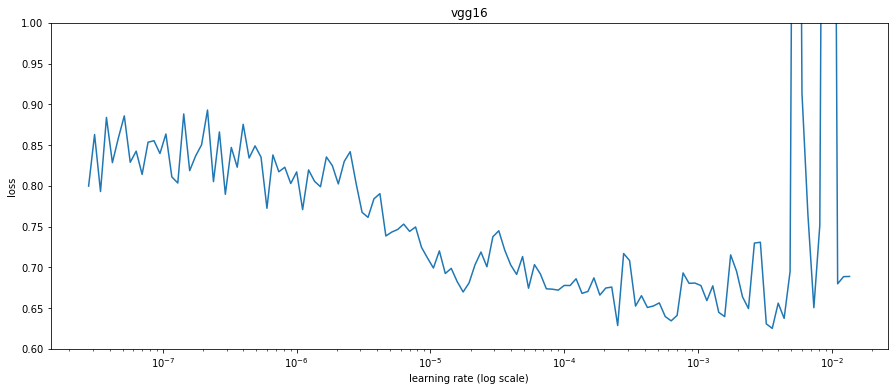

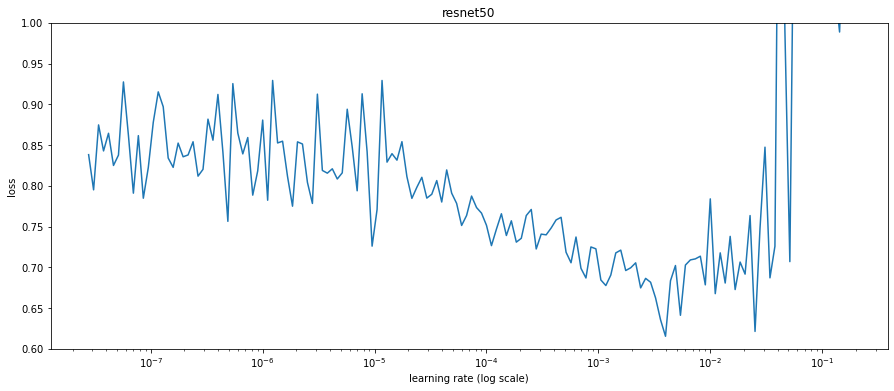

In [31]:
# Plot graphs to find suitable learning rates
plot_lr_loss(optimallr_vgg16_path, figure_title = 'vgg16', 
             n_skip_beginning=10, n_skip_end=5,
             outlier_cut = 100,
            plot_ylim = (0.6, 1) )
plot_lr_loss( optimallr_reasnet50_path, figure_title = 'resnet50', 
             n_skip_beginning=10, n_skip_end=5,
             outlier_cut = 100,
            plot_ylim = (0.6, 1) )

In [4]:
# From graph above, we can select lr range for each model, Howevers I decided to use only vgg16 futher as a time constrain
vgg16_lr_range = (4e-6, 2e-4)
resnet50_lr_range = (3e-5, 2e-3) 

In [6]:
from source.model import load_pretrained_VGG16, load_pretrained_ResNet50, build_my_model
from sklearn.metrics import precision_recall_curve
from source.train import TrainGen, make_val_gen
from source.train import build_callbacks_list
from source.train import train
import pandas as pd
import os

# read data
read_data_flag = 1
if read_data_flag:
    output_trainfile = os.path.join('processed_data', 'train_data.csv')
    output_valfile = os.path.join('processed_data', 'val_data.csv') 
    train_data, val_data = pd.read_csv(output_trainfile), pd.read_csv(output_valfile)
    train_gen = TrainGen(train_data)
    val_gen = make_val_gen(val_data, imgpath_col = 'path', class_col = 'pneumonia_class')


# vgg16 process
pretrained_vgg16 = load_pretrained_VGG16(lay_of_interest = 'block5_pool', trainable_after_layer = 17)
vgg16 = build_my_model(pretrained_vgg16)
model_name = 'vgg16'
weight_path = os.path.join('output', f"xray_class_{model_name}.best.hdf5")
callbacks_list = build_callbacks_list(weight_path = weight_path,
                                      validation_data = val_gen,
                                      patience = 40,
                                      initial_learning_rate = vgg16_lr_range[0],
                                      maximal_learning_rate = vgg16_lr_range[1],
                                      cyclical_lrstepsize = len(train_gen)*3)

with active_session():
    train(model = vgg16,
        callbacks_list = callbacks_list, 
        train_gen = train_gen, 
        validation_data = val_gen,
        epochs = 40,
        save_architecture_to = os.path.join('output', f'my_{model_name}.json'),
        save_history_to = os.path.join('output', f'history_{model_name}.npy') )

Found 2304 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
model check point paths are ['output/valloss_xray_class_vgg16.best.hdf5', 'output/PrecisionAtRecall80_xray_class_vgg16.best.hdf5']
Epoch 1/40
9/9 [==============================] - 92s 10s/step - loss: 4.2284 - val_loss: 5.8716

Epoch 00001: PrecisionAtRecall80 improved from -inf to 0.20028, saving model to output/PrecisionAtRecall80_xray_class_vgg16.best.hdf5

Epoch 00001: val_loss improved from inf to 5.87159, saving model to output/valloss_xray_class_vgg16.best.hdf5
Epoch 2/40
9/9 [==============================] - 36s 4s/step - loss: 2.8376 - val_loss: 3.1415

Epoch 00002: PrecisionAtRecall80 improved from 0.20028 to 0.20042, saving model to output/PrecisionAtRecall80_xray_class_vgg16.best.hdf5

Epoch 00002: val_loss improved from 5.87159 to 3.14153, saving model to output/valloss_xray_class_vgg16.best.hdf5
Epoch 3/40
9/9 [==============================] - 41s 5


Epoch 00020: PrecisionAtRecall80 improved from 0.25717 to 0.25906, saving model to output/PrecisionAtRecall80_xray_class_vgg16.best.hdf5

Epoch 00020: val_loss did not improve from 0.54969
Epoch 21/40
9/9 [==============================] - 43s 5s/step - loss: 0.6599 - val_loss: 0.6193

Epoch 00021: PrecisionAtRecall80 did not improve from 0.25906

Epoch 00021: val_loss did not improve from 0.54969
Epoch 22/40
9/9 [==============================] - 41s 5s/step - loss: 0.6555 - val_loss: 0.6345

Epoch 00022: PrecisionAtRecall80 improved from 0.25906 to 0.25980, saving model to output/PrecisionAtRecall80_xray_class_vgg16.best.hdf5

Epoch 00022: val_loss did not improve from 0.54969
Epoch 23/40
9/9 [==============================] - 43s 5s/step - loss: 0.6579 - val_loss: 0.6222

Epoch 00023: PrecisionAtRecall80 improved from 0.25980 to 0.26142, saving model to output/PrecisionAtRecall80_xray_class_vgg16.best.hdf5

Epoch 00023: val_loss did not improve from 0.54969
Epoch 24/40
9/9 [=======

# Predict validation set and save

In [6]:
from source.train import make_val_gen
from source.predict import predict
import pandas as pd

# predict vgg16
# read data
read_data_flag = 1
if read_data_flag:
    output_valfile = os.path.join('processed_data', 'val_data.csv') 
    val_data =pd.read_csv(output_valfile)
    val_gen = make_val_gen(val_data, imgpath_col = 'path', class_col = 'pneumonia_class')
model_name = 'vgg16'
model_path = os.path.join('output', f'my_{model_name}.json')
metrics = ['PrecisionAtRecall80', 'valloss']
for metric in metrics:
    weight_path = os.path.join('output', f"{metric}_xray_class_{model_name}.best.hdf5")
    predict(model_path, weight_path, val_gen, 
            prediction_path = os.path.join('output', f"{metric}_predval_{model_name}.npy"),
           groundtruth_path = os.path.join('output', f"groundtruth_{model_name}.npy"))

Using TensorFlow backend.


Found 1430 validated image filenames belonging to 2 classes.
6/6 [==============================] - 24s 4s/step


# Select best model with highest validation performance

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

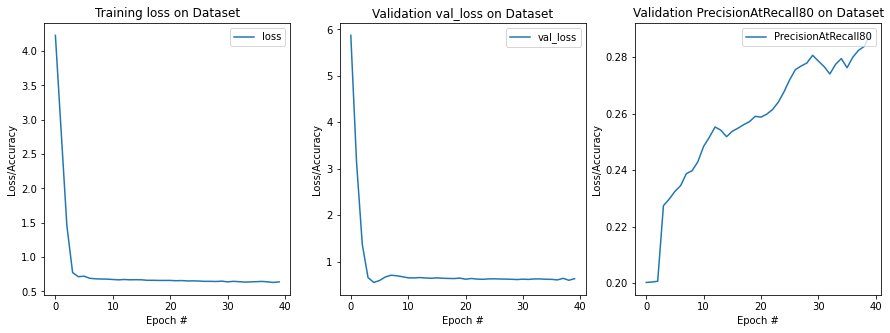

In [16]:
from source.predict import plot_auc, plot_history, calc_f1, plot_history
import os
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.


# see performance of vgg16   
model_name = 'vgg16'

# plot training history
plot_history(history_path = os.path.join('output', f'history_{model_name}.npy'))

## Plot performance of the best model from val_loss check point
This is the best model that provides lowest validation loss.

Using TensorFlow backend.


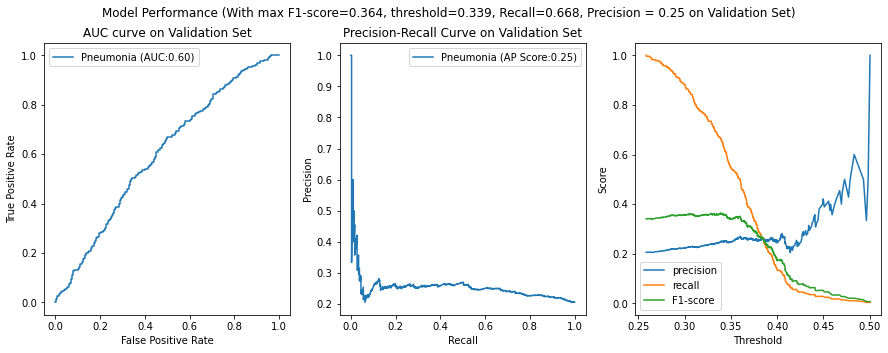

In [4]:
import os
from source.predict import load_model, plot_performance

# plot performance
metric = 'valloss'
model_name = 'vgg16'
groundtruth_path = os.path.join('output', f"groundtruth_{model_name}.npy")
prediction_path = os.path.join('output', f"{metric}_predval_{model_name}.npy")
plot_performance(prediction_path, groundtruth_path, title = f'Model Performance')

## Plot performance of the best model from PrecisionAtRecall80 check point
This is the best model that provides highest precision at recall>=0.8. 

The reason to use PrecisionAtRecall80 check point is that we want the model that can provide at least 0.8 of racall but also have a good precision score. 

/home/workspace/source/predict.py:121: RuntimeWarning: invalid value encountered in true_divide
  return 2.0*(prec*recall)/(prec+recall)


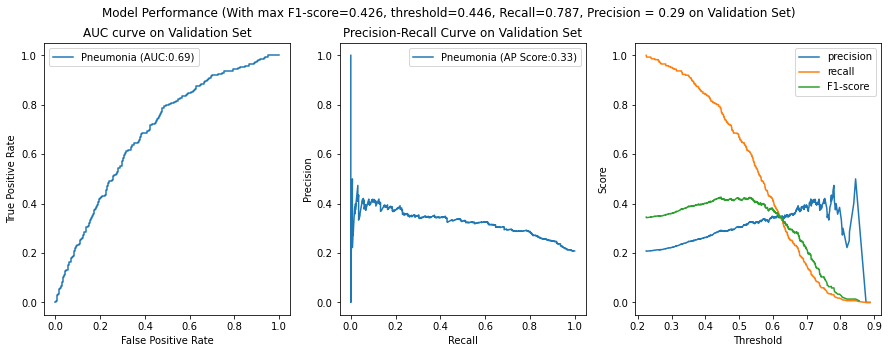

In [20]:
# plot performance
metric = 'PrecisionAtRecall80'
model_name = 'vgg16'
groundtruth_path = os.path.join('output', f"groundtruth_{model_name}.npy")
prediction_path = os.path.join('output', f"{metric}_predval_{model_name}.npy")
plot_performance(prediction_path, groundtruth_path, title = f'Model Performance')

From graph above, It seems that the best model with PrecisionAtRecall80 checkpoint provide better performance on the validation than the one from val_loss checkpoint because it provides higher AUC and maximum F1-score. Validation loss tend to satisfy the majority class so it may not be the good indicator on the very impalanced validation data.

The reason to use PrecisionAtRecall80 check point is that we want the model that can provide at least 0.8 of racall but also have a good precision score. 

Thus, the selected model will be the best model with PrecisionAtRecall80 checkpoint.

Interesting site: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/PrecisionAtRecall

# Select the threshold

In [20]:
import os
import numpy as np
from source.predict import precision_recall_curve, calc_f1
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
metric = 'PrecisionAtRecall80'
model_name =  'vgg16'
prediction_path = os.path.join('output', f"{metric}_predval_{model_name}.npy")
groundtruth_path = os.path.join('output', f"groundtruth_{model_name}.npy")
probability = np.load(prediction_path)
ground_truth = np.load(groundtruth_path)
precision, recall, thresholds = precision_recall_curve(ground_truth, probability)
precision = precision[:-1]
recall = recall[:-1]
condition_index = (recall >= 0.8)
precision = precision[condition_index]
thresholds = thresholds[condition_index]
recall = recall[condition_index]
print(f'select thresholds = {thresholds[-1]:.2} with gives precision = {precision[-1]:.2}, recall = {recall[-1]:.2}, f1 = {calc_f1(precision[-1], recall[-1]):.2} ')
YOUR_THRESHOLD = thresholds[-1] # to have recall >= 0.8 

select thresholds = 0.44 with gives precision = 0.29, recall = 0.8, f1 = 0.42 


In [6]:
YOUR_THRESHOLD

0.43900916

# Load our our best model and look at some examples of true vs. predicted

In [23]:
from source.predict import load_model
from source.train import make_val_gen

# read validation data
read_data_flag = 1
if read_data_flag:
    output_valfile = os.path.join('processed_data', 'val_data.csv') 
    val_data =pd.read_csv(output_valfile)
    val_gen = make_val_gen(val_data, imgpath_col = 'path', class_col = 'pneumonia_class')
    
# load best model
metric = 'PrecisionAtRecall80'
model_name = 'vgg16'
weight_path =  os.path.join('output', f"{metric}_xray_class_{model_name}.best.hdf5")
best_model =  load_model(model_path = os.path.join('output', f'my_{model_name}.json'), 
                   weight_path =  weight_path)

# Prepare examples of validation data
valX = []
valY = []
lenght = 0
while 1:
    this_valX, this_valY = val_gen.next()
    lenght += this_valY.shape[0]
    valX.append(this_valX)
    valY.append(this_valY)
    if lenght >= 100:
        break
valX = np.concatenate(valX)   
valY = np.concatenate(valY)

Found 1430 validated image filenames belonging to 2 classes.


In [24]:
# get prediction
pred_Y = best_model.predict(valX, batch_size = 32, verbose = True).flatten()

256/256 [==============================] - 149s 580ms/step


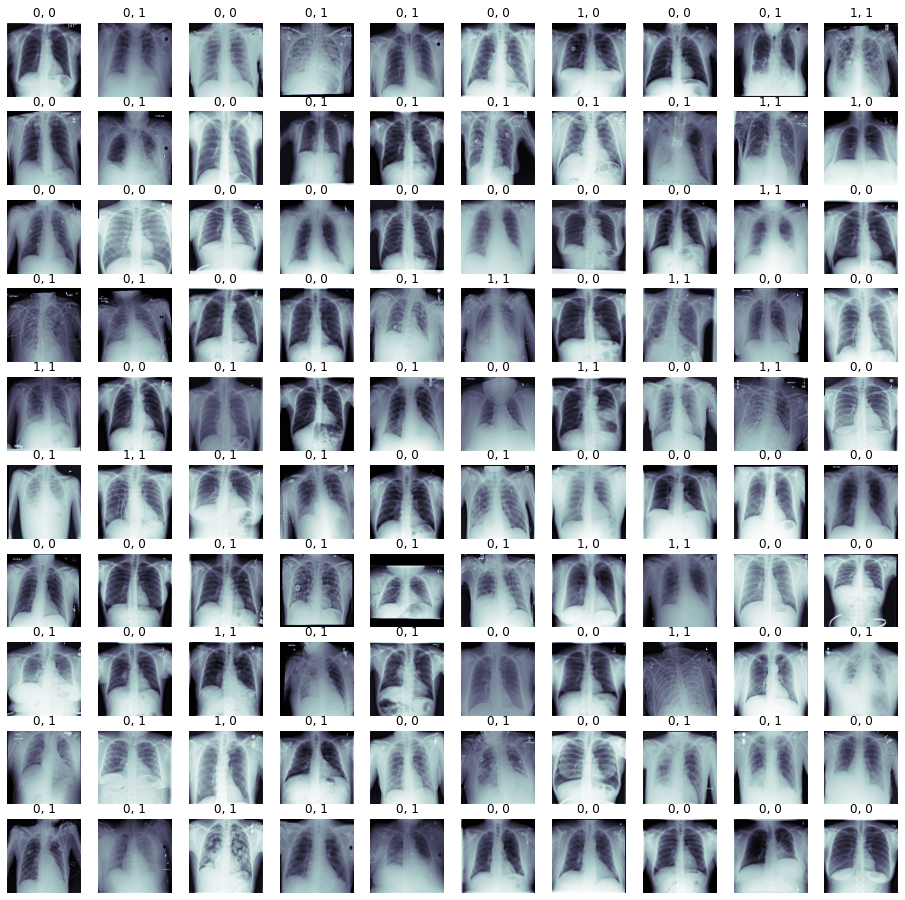

In [32]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] >= YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] >= YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

# Model performance in the presence of other diseases that comorbid with pneumonia

In [16]:
import pandas as pd

# load validation data
output_valfile = os.path.join('processed_data', 'val_data.csv') 
val_data = pd.read_csv(output_valfile)

# load prediction info
metric = 'PrecisionAtRecall80'
model_name =  'vgg16'
prediction_path = os.path.join('output', f"{metric}_predval_{model_name}.npy")
probability = np.load(prediction_path)
val_data['Pneumonia_predict'] = probability
val_data['Image Index'] = val_data['path'].map(os.path.basename)
val_data = val_data[['Image Index', 'Pneumonia_predict']]
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df = all_xray_df[['Image Index', 'Finding Labels']]
all_xray_df['Finding Labels'] =  all_xray_df['Finding Labels'].str.split('|')
all_labels = all_xray_df['Finding Labels'].explode().unique()
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(set)
val_data = pd.merge(val_data, all_xray_df, on = 'Image Index')
for label in all_labels:
    val_data[label] = val_data['Finding Labels'].map(lambda x: 1 if label in x else 0)
val_data

,Image Index,Pneumonia_predict,Finding Labels,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00015485_003.png,0.272683,{No Finding},0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,00013641_045.png,0.622597,{Edema},0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,00016833_001.png,0.217025,{No Finding},0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,00018104_007.png,0.752083,{Edema},0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,00022235_011.png,0.671313,"{Atelectasis, Mass}",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1425,00018860_003.png,0.698323,{Atelectasis},0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1426,00026656_000.png,0.646253,"{Atelectasis, Effusion, Infiltration, Consolid...",0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
1427,00005064_001.png,0.693649,{No Finding},0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1428,00010811_000.png,0.244668,{No Finding},0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [17]:
from sklearn.metrics import precision_recall_fscore_support
from source.predict import calc_f1
performance = {'label': [], 'precision': [], 'recall': [], 'f1': [], 'num_cases': []}
for item in all_labels: 
    if (item == 'No Finding') | (item == 'Pneumonia'):
        continue
    subtable = val_data[val_data[item] == 1]
    y_pred = subtable.Pneumonia_predict.tolist()
    y_true = subtable.Pneumonia.tolist()  
    precision, recall, f1, support= precision_recall_fscore_support(y_true, np.asarray(y_pred) >= 0.44090602)    
    performance['label'].append(item)
    performance['precision'].append(precision[1])
    performance['recall'].append(recall[1])
    performance['f1'].append(f1[1])
    performance['num_cases'].append(sum(support))
performance = pd.DataFrame(performance)
performance = performance.sort_values('f1')
performance

,label,precision,recall,f1,num_cases
1,Emphysema,0.166667,1.000000,0.285714,37
6,Nodule,0.219512,0.642857,0.327273,72
8,Pneumothorax,0.224490,1.000000,0.366667,62
5,Mass,0.301887,0.842105,0.444444,77
10,Fibrosis,0.285714,1.000000,0.444444,16
7,Atelectasis,0.377193,0.716667,0.494253,163
0,Cardiomegaly,0.333333,1.000000,0.500000,28
9,Pleural_Thickening,0.343750,0.916667,0.500000,40
12,Consolidation,0.369231,0.827586,0.510638,81
2,Effusion,0.363057,0.919355,0.520548,186


In [18]:
performance[(performance.f1 < 0.426 )].sort_values('f1')

,label,precision,recall,f1,num_cases
1,Emphysema,0.166667,1.000000,0.285714,37
6,Nodule,0.219512,0.642857,0.327273,72
8,Pneumothorax,0.224490,1.000000,0.366667,62


In [19]:
performance[(performance.f1 > 0.426)].sort_values('f1')

,label,precision,recall,f1,num_cases
5,Mass,0.301887,0.842105,0.444444,77
10,Fibrosis,0.285714,1.000000,0.444444,16
7,Atelectasis,0.377193,0.716667,0.494253,163
0,Cardiomegaly,0.333333,1.000000,0.500000,28
9,Pleural_Thickening,0.343750,0.916667,0.500000,40
12,Consolidation,0.369231,0.827586,0.510638,81
2,Effusion,0.363057,0.919355,0.520548,186
4,Infiltration,0.459227,0.884298,0.604520,316
11,Edema,0.790123,1.000000,0.882759,83
3,Hernia,1.000000,1.000000,1.000000,2


The presence of Emphysema or Nodule may reduce the model performance of the algorithm in accurately predicting the presence of pneumonia in a chest x-ray. Conversely, the presence of Edema, Infiltration, or Consolidation in the image may lead to improved performance of the algorithm at accurately predicting the presence of pneumonia from a chest x-ray.

# Show model achitecture

In [13]:
from source.predict import load_model
import os
model_name = 'vgg16'
metric = 'PrecisionAtRecall80'
model =  load_model(model_path = os.path.join('output', f'my_{model_name}.json'), 
                   weight_path =  os.path.join('output', f"{metric}_xray_class_{model_name}.best.hdf5"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 2,384,897
Non-trainable params: 12,354,880
_________________________________________________________________


In [15]:
model.get_layer('model_2').summary() 

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   